# Unit 2 Homework - Bikeshare 

_Author: Theresa Waters_

- Description: This dataset counts hourly bike rentals throughout a city over the course of 2 years.  It contains around 10,000 samples that logs information about the weather at that point in time, as well as the date.


- Questions that could be answered: How do time based characteristics like time of day and previously occurring trends impact the ability to forecast total rentals?  What about weather?  This dataset is primarily about being able to accurately capture the impact of time on your target variable.


## Imports

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline

In [30]:
bike = pd.read_csv('data/bikeshare.csv')

## 1. Explore the dataset

In [31]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  object 
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  object 
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   count       10886 non-null  int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 850.6+ KB


In [4]:
bike.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,Spring,0,0,Clear Skies,9.84,14.395,81,0.0,16
1,2011-01-01 01:00:00,Spring,0,0,Clear Skies,9.02,13.635,80,0.0,40
2,2011-01-01 02:00:00,Spring,0,0,Clear Skies,9.02,13.635,80,0.0,32
3,2011-01-01 03:00:00,Spring,0,0,Clear Skies,9.84,14.395,75,0.0,13
4,2011-01-01 04:00:00,Spring,0,0,Clear Skies,9.84,14.395,75,0.0,1


In [5]:
bike.shape

(10886, 10)

### 1.1 Clean

In [6]:
#check for missing values - NONE 

bike.isnull().sum() 

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
count         0
dtype: int64

### 1.2 Visualizations

- Note: count data is the target

#### 1.2.1 Count Distribution

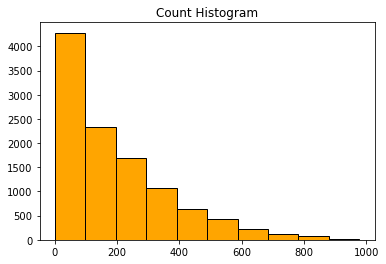

In [6]:
# Count histogram: 

plt.hist(bike['count'], color = "orange", edgecolor = 'black')
plt.title('Count Histogram');

- Distribution is skewed to the right
- Would prefer a normal distribution


#### 1.2.2 Visual Comparisons



- Categorical variables

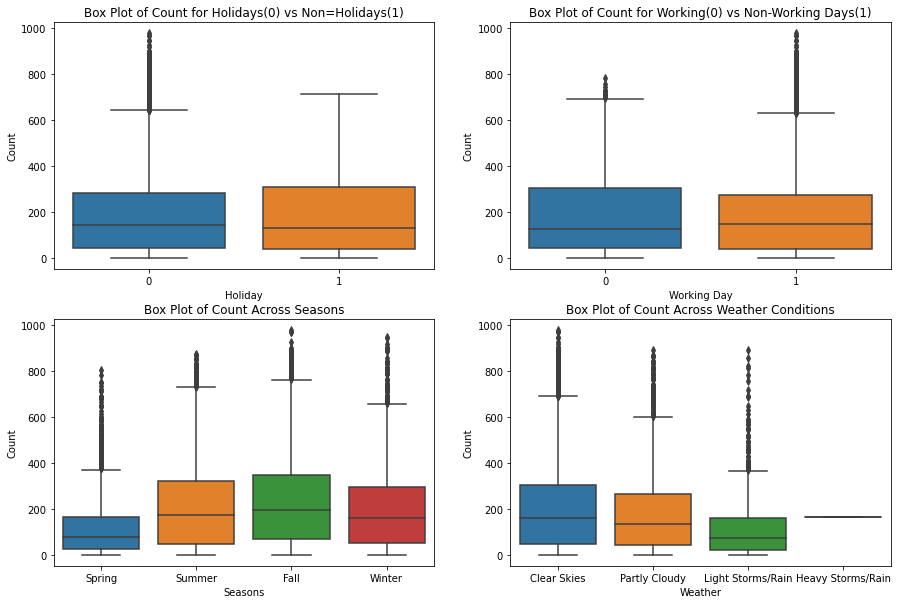

In [64]:
fig, ax = plt.subplots(2, 2, figsize = (15, 10))

sns.boxplot(data=bike,x = "holiday", y="count",ax=ax[0][0])
sns.boxplot(data=bike,x = "workingday", y="count", ax=ax[0][1])
sns.boxplot(data=bike,x = "season", y="count",ax=ax[1][0])
sns.boxplot(data=bike,x = "weather", y="count",ax=ax[1][1])


ax[0][0].set(xlabel='Holiday', ylabel='Count',title="Box Plot of Count for Holidays(0) vs Non=Holidays(1)")
ax[0][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot of Count for Working(0) vs Non-Working Days(1)")
ax[1][0].set(xlabel='Seasons', ylabel='Count',title="Box Plot of Count Across Seasons")
ax[1][1].set(xlabel='Weather', ylabel='Count',title="Box Plot of Count Across Weather Conditions");






- Outliers contributing to the skew of the count data
- No significant differences in average rentals on holidays vs non-holidays or working days vs non-working days - however, should look at the overall demand on these days for all the count data - interested in seeing the hourly trends for these data 
- Trend of less rentals in the Spring 



- Also want to look at value count data to get a better idea of the demand 



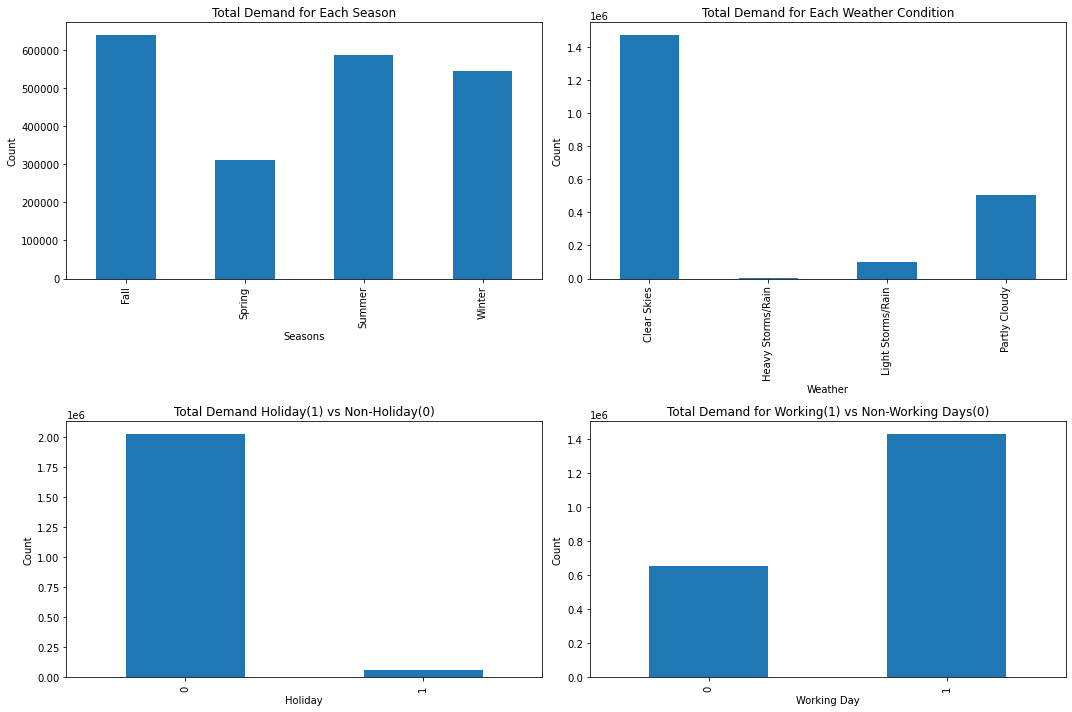

In [183]:
fig, ax = plt.subplots(2, 2, figsize = (15, 10))

bike.groupby('season')['count'].sum().plot.bar(ax=ax[0][0])
bike.groupby('weather')['count'].sum().plot.bar(ax=ax[0][1])
bike.groupby('holiday')['count'].sum().plot.bar(ax=ax[1][0])
bike.groupby('workingday')['count'].sum().plot.bar(ax=ax[1][1])


ax[1][0].set(xlabel='Holiday', ylabel='Count',title="Total Demand Holiday(1) vs Non-Holiday(0)")
ax[1][1].set(xlabel='Working Day', ylabel='Count',title="Total Demand for Working(1) vs Non-Working Days(0)")
ax[0][0].set(xlabel='Seasons', ylabel='Count',title="Total Demand for Each Season")
ax[0][1].set(xlabel='Weather', ylabel='Count',title="Total Demand for Each Weather Condition")

plt.tight_layout();


- Clear difference in demands: 
    - Lower demand in Spring: interesting, would expect lowest demand in the winter 
    - Highest demand when weather is clear - makes sense
    - Very little to no demand in poor weather 
    - Holidays make up an extremely small proportion of the data 
    - Higher overall demand on working days - makes sense since there are 5 working days in the week versus two days on the weekend

#### 1.2.3 Datetime

- Convert bike['datetime'] to datetime from object 
- Datetime: year, month, day, hour

In [32]:
from datetime import datetime as dt

bike['datetime'] = pd.to_datetime(bike['datetime'])

In [33]:
bike['year'] = bike['datetime'].dt.year
bike['month'] = bike['datetime'].dt.month
bike['day'] = bike['datetime'].dt.weekday
bike['hour'] = bike['datetime'].dt.hour


In [82]:
bike.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,2011-01-01 00:00:00,Spring,0,0,Clear Skies,9.84,14.395,81,0.0,16,2011,1,5,0
1,2011-01-01 01:00:00,Spring,0,0,Clear Skies,9.02,13.635,80,0.0,40,2011,1,5,1
2,2011-01-01 02:00:00,Spring,0,0,Clear Skies,9.02,13.635,80,0.0,32,2011,1,5,2
3,2011-01-01 03:00:00,Spring,0,0,Clear Skies,9.84,14.395,75,0.0,13,2011,1,5,3
4,2011-01-01 04:00:00,Spring,0,0,Clear Skies,9.84,14.395,75,0.0,1,2011,1,5,4


- Visualize counts based on datetime

In [6]:
#First want to get average counts per month and hours(per weekday)

#months first - new dataframe

monthAvg = pd.DataFrame(bike.groupby("month")["count"].mean()).reset_index()
monthAvg.head()

,month,count
0,1,90.366516
1,2,110.003330
2,3,148.169811
3,4,184.160616
4,5,219.459430


In [7]:
#Now for hours per weekdays

hourAvg = pd.DataFrame(bike.groupby(["hour", "day"], sort=True)["count"].mean()).reset_index()
hourAvg

,hour,day,count
0,0,0,35.492308
1,0,1,27.328125
2,0,2,36.246154
3,0,3,37.476923
4,0,4,53.234375
...,...,...,...
163,23,2,80.138462
164,23,3,99.630769
165,23,4,119.546875
166,23,5,120.030303


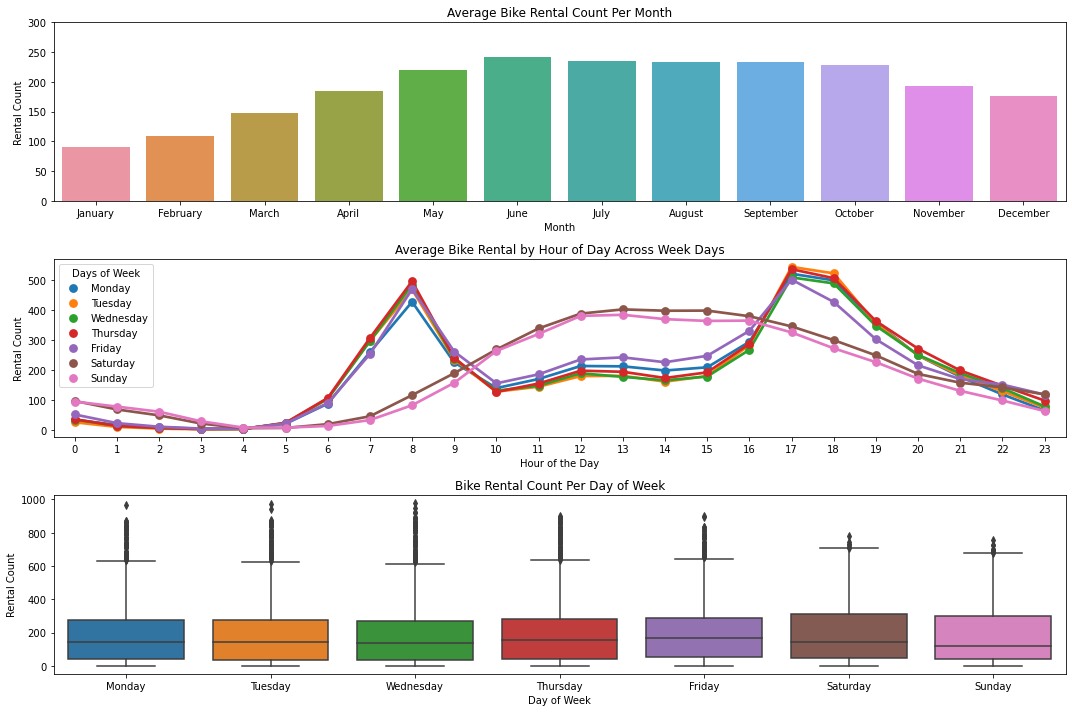

In [8]:
#First: month and days of week are numbered - create list with proper order and name 

ordered_months = ["January","February","March","April","May","June","July","August","September","October","November","December"]
ordered_days = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday", "Sunday"]

#Second: plot! 

fig, ax = plt.subplots(3, figsize = (15, 10))

#A) Count by month 

sns.barplot(data=monthAvg,x="month",y="count",ax=ax[0])
ax[0].set_xticklabels(ordered_months)
ax[0].set_ylim(0, 300)
ax[0].set(xlabel="Month", ylabel="Rental Count", title="Average Bike Rental Count Per Month")

#B) Count by hour across the weekdays 
hour_plt = sns.pointplot(data=hourAvg,x="hour",y="count", hue="day", join=True, ax=ax[1])
hour_plt
#replacing the legend labels 
leg = hour_plt.get_legend()
new_title = 'Days of Week'
leg.set_title(new_title)
new_labels = ordered_days
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)

ax[1].set(xlabel='Hour of the Day', ylabel='Rental Count', title='Average Bike Rental by Hour of Day Across Week Days');

#C)Count by weekday 
sns.boxplot(data=bike,x = "day", y="count",ax=ax[2])
ax[2].set(xlabel="Day of Week", ylabel="Rental Count", title="Bike Rental Count Per Day of Week")
ax[2].set_xticklabels(ordered_days)

plt.tight_layout();


- Looking at counts per month versus per season gives a better of how rental use fluctuates throughout the year 
- Average counts for weekdays versus weekends in the boxplots did not seem to significantly differ, however, looking at the hourly rentals per day of the week - the hours of rental use differ between the weekdays (most use before and after work) and weekends (most use during the middle of the day) 

## 2. Correlations


- Relationship between temperature and atemp (feels-like) - is there a big difference?



<AxesSubplot:xlabel='temp', ylabel='atemp'>

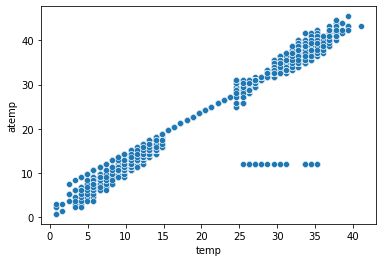

In [9]:
sns.scatterplot(data = bike, x = 'temp', y = 'atemp')

- Looks like the correlation betwen the two temperature is basically 1:1 

In [10]:
bike[['temp','atemp']].corr()

,temp,atemp
temp,1.000000,0.984948
atemp,0.984948,1.000000


#### 2.1 Pairplots

In [135]:
bike.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,2011-01-01 00:00:00,Spring,0,0,Clear Skies,9.84,14.395,81,0.0,16,2011,1,5,0
1,2011-01-01 01:00:00,Spring,0,0,Clear Skies,9.02,13.635,80,0.0,40,2011,1,5,1
2,2011-01-01 02:00:00,Spring,0,0,Clear Skies,9.02,13.635,80,0.0,32,2011,1,5,2
3,2011-01-01 03:00:00,Spring,0,0,Clear Skies,9.84,14.395,75,0.0,13,2011,1,5,3
4,2011-01-01 04:00:00,Spring,0,0,Clear Skies,9.84,14.395,75,0.0,1,2011,1,5,4


#### 2.1.1 temp, atemp, humidity, windspeed

In [34]:
bike_int_var_with_count = bike[['temp', 'atemp', 'humidity', 'windspeed', 'count']]
bike_int_variables = bike[['temp', 'atemp', 'humidity', 'windspeed']]
bike_count = bike['count']

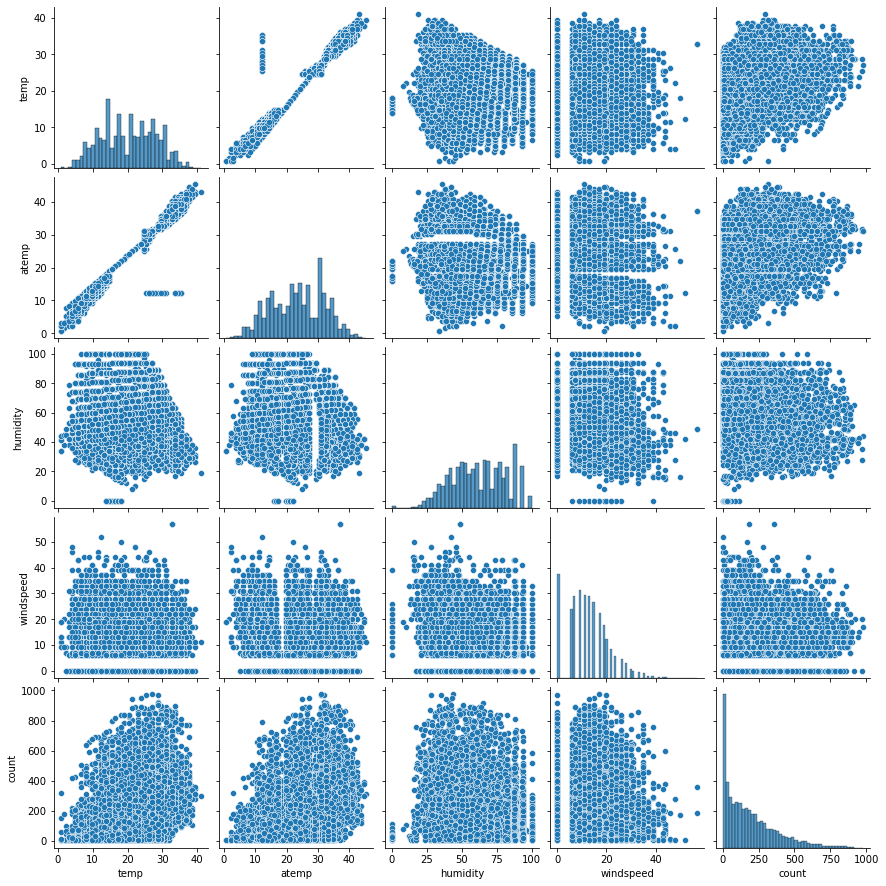

In [13]:
sns.pairplot(bike_int_var_with_count);

- From this pairplot it looks like temp and atemp have a positive correlation with count, the relationships with the other variables are not as clear
- Look a little more closely at visualizations for the different numerical variables


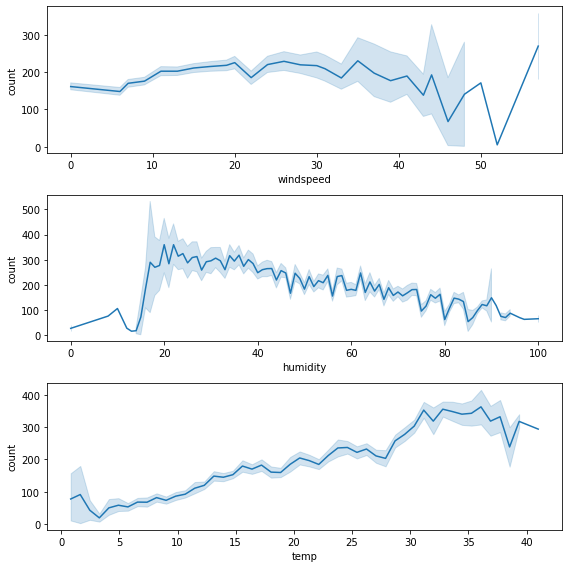

In [14]:
fig, ax = plt.subplots(3, figsize = (8, 8))

sns.lineplot(x=bike['windspeed'], y=bike['count'], ax=ax[0])
sns.lineplot(x=bike['humidity'], y=bike['count'], ax=ax[1])
sns.lineplot(x=bike['temp'], y=bike['count'], ax=ax[2])

plt.tight_layout();

- Clearer trends for humidity and temp (temp the clearest trend), windspeed is a bit more complicated - why do counts spike up at 50+ mph gusts? 
- As humidity increases, count decreases - makes sense, humidity is uncomfortable
- As temperature increases, count increases - people like to bike more when it's warm! 

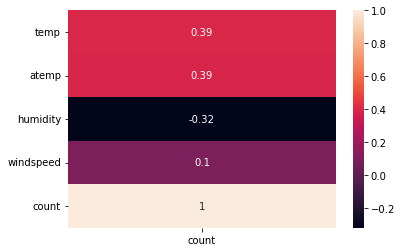

In [12]:
sns.heatmap(bike_int_var_with_count.corr()[['count']], annot = True);

- Confirmed strongest correlation is with temp and atemp 
- Humidity has a pretty decent negative correlation 
- Windspeed has a low correlation

#### 2.1.2 date values 


In [ ]:
bike.head(1)

In [17]:
bike_datetime = bike[['year', 'month', 'day', 'hour', 'count']]

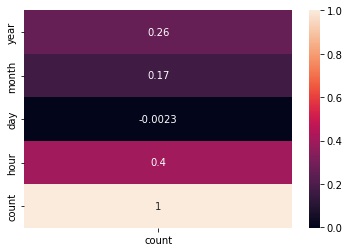

In [18]:
sns.heatmap(bike_datetime.corr()[['count']], annot = True);

- Makes sense that the strongest correlation is for hour considering how the hour, based on day of the week, looks to have a strong influence on rental counts
- Month is surprisngly low considering there seemed to be a trend in the data per month - but is it better than using season?

# 3. Models - Linear Regression

- Make models to see how well we can predict the 'count' results

#### 3.1 Turn objects into categorical features 

In [35]:
bike.head(1)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,2011-01-01,Spring,0,0,Clear Skies,9.84,14.395,81,0.0,16,2011,1,5,0


In [18]:
categorical_features = ['season', 'workingday', 'weather', 'month', 'day', 'hour']


In [19]:
for var in categorical_features:
    bike[var] = bike[var].astype("category")

In [20]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  category      
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  category      
 4   weather     10886 non-null  category      
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   count       10886 non-null  int64         
 10  year        10886 non-null  int64         
 11  month       10886 non-null  category      
 12  day         10886 non-null  category      
 13  hour        10886 non-null  category      
dtypes: category(6), datetime64[ns](1), float64(3), int64(4)
memory usage: 746.3 KB


#### 3.2 Make numeric values scaler

In [36]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

numeric_features = ['temp', 'atemp', 'humidity', 'windspeed', 'count']

bike[numeric_features] = scaler.fit_transform(bike[numeric_features])




In [37]:
bike.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,2011-01-01 00:00:00,Spring,0,0,Clear Skies,-1.333661,-1.092737,0.993213,-1.567754,-0.969294,2011,1,5,0
1,2011-01-01 01:00:00,Spring,0,0,Clear Skies,-1.438907,-1.182421,0.941249,-1.567754,-0.836797,2011,1,5,1
2,2011-01-01 02:00:00,Spring,0,0,Clear Skies,-1.438907,-1.182421,0.941249,-1.567754,-0.880962,2011,1,5,2
3,2011-01-01 03:00:00,Spring,0,0,Clear Skies,-1.333661,-1.092737,0.681430,-1.567754,-0.985856,2011,1,5,3
4,2011-01-01 04:00:00,Spring,0,0,Clear Skies,-1.333661,-1.092737,0.681430,-1.567754,-1.052104,2011,1,5,4


In [38]:
bike.describe()

,holiday,workingday,temp,atemp,humidity,windspeed,count,year,month,day,hour
count,10886.000000,10886.000000,1.088600e+04,1.088600e+04,1.088600e+04,1.088600e+04,1.088600e+04,10886.000000,10886.000000,10886.000000,10886.000000
mean,0.028569,0.680875,1.036139e-14,-3.990153e-15,-1.667583e-15,-6.407188e-16,1.117005e-15,2011.501929,6.521495,3.013963,11.541613
std,0.166599,0.466159,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,0.500019,3.444373,2.004585,6.915838
min,0.000000,0.000000,-2.491372e+00,-2.701736e+00,-3.215858e+00,-1.567754e+00,-1.052104e+00,2011.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,-8.074281e-01,-8.248654e-01,-7.735577e-01,-7.101642e-01,-8.257554e-01,2011.000000,4.000000,1.000000,6.000000
50%,0.000000,1.000000,3.454398e-02,6.902305e-02,5.899992e-03,2.432639e-02,-2.571223e-01,2012.000000,7.000000,3.000000,12.000000
75%,0.000000,1.000000,7.712696e-01,8.738177e-01,7.853577e-01,5.142603e-01,5.102564e-01,2012.000000,10.000000,5.000000,18.000000
max,1.000000,1.000000,2.665707e+00,2.572501e+00,1.980526e+00,5.413599e+00,4.336108e+00,2012.000000,12.000000,6.000000,23.000000


#### 3.3 Linear Regression Model #1


In [58]:
X = bike.drop(['datetime', 'holiday', 'count', 'year'], axis='columns')
y = bike['count']
X['season'] = X['season'].astype('category').cat.codes
X['weather'] = X['weather'].astype('category').cat.codes


              

In [59]:
X.head(2)

,season,workingday,weather,temp,atemp,humidity,windspeed,month,day,hour
0,1,0,0,-1.333661,-1.092737,0.993213,-1.567754,1,5,0
1,1,0,0,-1.438907,-1.182421,0.941249,-1.567754,1,5,1


In [69]:
#instatiate 

lr = LinearRegression()

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [71]:
lr.fit(X_train, y_train)

LinearRegression()

In [72]:
lr.intercept_

-0.8438941772282856

In [73]:
lr.coef_

array([ 0.10868098,  0.01639229,  0.01329461,  0.22696579,  0.13254947,
       -0.24230759,  0.00515739,  0.02367445,  0.00597446,  0.04175762])

In [133]:
coefficients = pd.DataFrame([X_train.columns, lr.coef_]).T
coefficients = coefficients.rename(columns={0: 'Feature', 1: 'Coefficients'})
coefficients


,Feature,Coefficients
0,season,0.108681
1,workingday,0.016392
2,weather,0.013295
3,temp,0.226966
4,atemp,0.132549
5,humidity,-0.242308
6,windspeed,0.005157
7,month,0.023674
8,day,0.005974
9,hour,0.041758


- Most important features: season, temp, and humidity
- Datetime info do not have as strong of an influence 

In [129]:
#Cross validation 

cross_val_score(lr, X_train, y_train, scoring = 'neg_mean_squared_error')

array([-0.63744304, -0.62464281, -0.69027531, -0.68950824, -0.62612825])

In [81]:
y_pred = lr.predict(X_test)

In [124]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

0.6646984392340349

In [96]:
print(f'Train Accuracy: {lr.score(X_train, y_train)}')
print(f'Test Accuracy: {lr.score(X_test, y_test)}')

Train Accuracy: 0.3477290156072905
Test Accuracy: 0.3353773446696542


- Visualize Pred vs Actual 

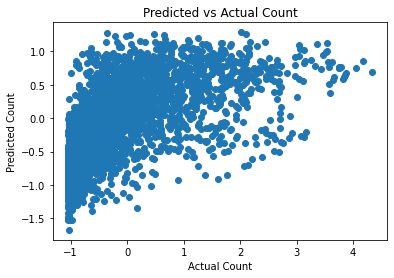

In [100]:
plt.scatter(y_test, y_pred)
plt.title('Predicted vs Actual Count')
plt.xlabel('Actual Count')
plt.ylabel('Predicted Count');


- Plot the residuals

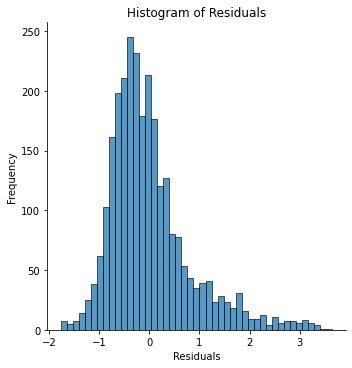

In [95]:
sns.displot(y_test-y_pred)
plt.title('Histogram of Residuals')
plt.xlabel("Residuals")
plt.ylabel("Frequency");


#### 3.4 Polynomial Regression Model #2

In [101]:
poly_features = PolynomialFeatures(degree=2)

In [103]:
#Fit and transform train 

X_train_quad = poly_features.fit_transform(X_train)

In [105]:
bi_quad = LinearRegression().fit(X_train_quad, y_train)

In [106]:
#Predict on training set 

y_train_quad_pred = bi_quad.predict(X_train_quad)

In [112]:
#Predict on test set 

X_test_quad = poly_features.fit_transform(X_test)

y_test_quad_pred = bi_quad.predict(poly_features.fit_transform(X_test))
y_test_quad_pred

array([ 0.64446043, -0.8146988 ,  0.05770255, ..., -0.42411632,
        0.1905617 , -0.1224416 ])

In [125]:
mean_squared_error(bi_quad.predict(X_test_quad), y_test)

0.5170742476140106

- Better than the first linear model 

#### 3.4.1 Can also do this using a pipeline

In [117]:
from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config('diagram')


In [119]:
poly_features = PolynomialFeatures(degree=2)
X_train_polyfeatures = poly_features.fit_transform(X_train)
X_test_polyfeatures = poly_features.transform(X_test)

In [120]:
#Pipeline to poly then regressor
quad_pipe = Pipeline([('polynomial_features', PolynomialFeatures(include_bias=False)),
                     ('regressor', LinearRegression())])

In [121]:
quad_pipe

Pipeline(steps=[('polynomial_features', PolynomialFeatures(include_bias=False)),
                ('regressor', LinearRegression())])

In [122]:
#Cross validate 

cross_val_score(quad_pipe, X_train, y_train, scoring = 'neg_mean_squared_error')

array([-0.49819644, -0.489154  , -0.54223328, -0.53451687, -0.48569066])

- Array looks better than Model #1 cross validation

In [123]:
#Evaluate on the test 

quad_pipe.fit(X_train, y_train)
preds = quad_pipe.predict(X_test)
mean_squared_error(y_test, preds)

0.5170742476140094

#### 3.5 Running the model with day and windspeed dropped (lowest coefficients in model #1)

In [155]:
X_imp = bike.drop(['datetime', 'holiday', 'count', 'year', 'day', 'windspeed'], axis='columns')
y = bike['count']
X_imp['season'] = X_imp['season'].astype('category').cat.codes
X_imp['weather'] = X_imp['weather'].astype('category').cat.codes




In [157]:
#train test split 

X_imp_train, X_imp_test, y_train, y_test = train_test_split(X_imp, y, random_state=42)

In [158]:
poly_features = PolynomialFeatures(degree=2)
X_imp_train_polyfeatures = poly_features.fit_transform(X_imp_train)
X_imp_test_polyfeatures = poly_features.transform(X_imp_test)

In [159]:
#cross validate 

cross_val_score(quad_pipe, X_imp_train, y_train, scoring = 'neg_mean_squared_error')

array([-0.49463546, -0.4915682 , -0.53940863, -0.53694076, -0.48756994])

- Cross validation does not seem that different from Model #2 (quad)

In [160]:
#Evaluate on the test 

quad_pipe.fit(X_imp_train, y_train)
preds = quad_pipe.predict(X_imp_test)
mean_squared_error(y_test, preds)

0.5179722177144127

- Actually slightly worse - will stick to Model #2